In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import io
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
from IPython.display import clear_output
from numpy.typing import NDArray
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

In [3]:
from qml.model.gate import get_gateset, Gate, GateInfo
from qml.model.unit import Unit, EmbedUnit, EntangleUnit
from qml.model.model import Model
from qml.tools.trainer import calc_gradients
from qml.tools.dataloader import DataLoader
from qml.tools.evaluator import Evaluator
from qml.optimizer.localsearch import LocalSearchOptimizer


In [8]:
%matplotlib inline
np.set_printoptions(precision=3, floatmode='fixed')

## Parameters

In [11]:
# circuit
nq = 2
ng = 3
num_trial_unit = 9

# dataset
nx = 1
num_train_data = 20
num_test_data = 20
gateset = get_gateset(nq)

# optimization
shots = 50
num_iter =  100
variance = 0.3

## Dataset

In [12]:
target_func = lambda x: np.sin(np.pi * x)

In [13]:
train_xs = np.random.uniform(-1, 1, num_train_data)
train_ys = target_func(train_xs)
train_data = [train_xs, train_ys]

test_xs = np.random.uniform(-1, 1, num_test_data)
test_ys = target_func(test_xs)
test_data = [test_xs, test_ys]

## Prepare

In [14]:
# Optimizer
optim = LocalSearchOptimizer(train_data, test_data, shots=shots, variance=variance)

In [18]:
def generate_random_units(name_root, nq, ng, gateset, num_trial_unit, with_entangle_unit=False):
    def gen_unit(i):
        unit = Unit.generate_random_unit(name_root+f"_{i}", nq, ng, gateset=gateset)
        if not with_entangle_unit:
            return [unit]
        return [
            unit, EntangleUnit.new_neighbor_cz(name_root+"_ent", nq, gateset=gateset)
        ]
    
    return [
        gen_unit(i) for i in range(num_trial_unit)
    ]

emb = EmbedUnit.generate_ry_arcsin_embed_unit("emb", nq, nx, gateset=gateset)
units = generate_random_units("tr1", nq, ng, gateset, num_trial_unit, with_entangle_unit=True)
models = [
    Model(nq, 1, emb, [], unit)
    for unit in units
]

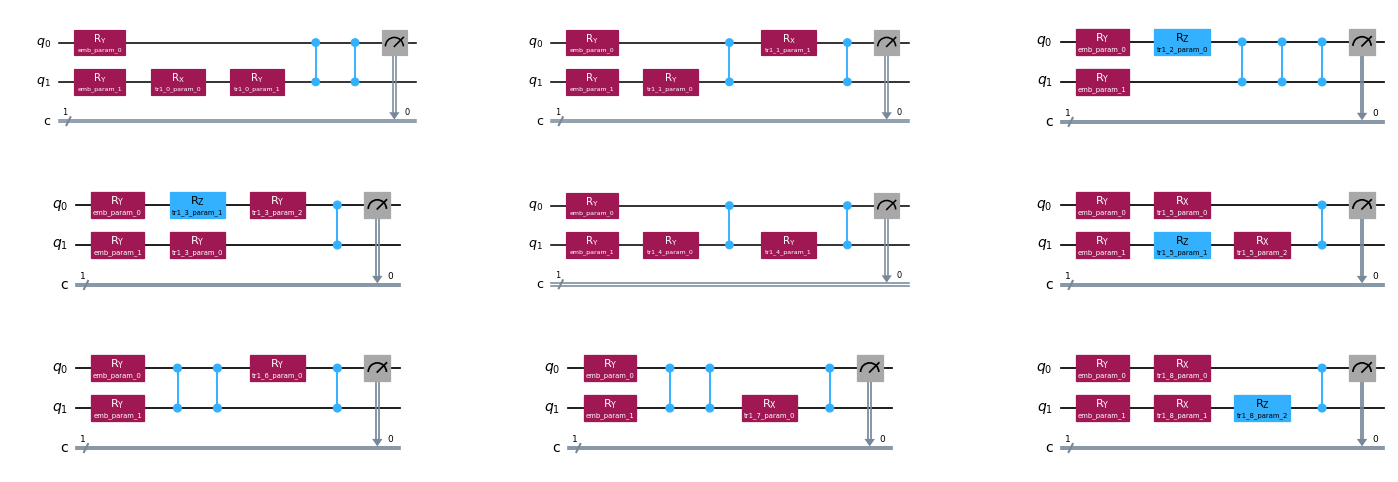

In [19]:
def plot_model_list(models, axes):
    for ax, model in zip(axes.flatten(), models):
        model.draw(ax=ax)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 6))
plot_model_list(models, axes)